1. Setup and Load data

1.1 Install libraries

In [48]:
!pip install tensorflow opencv-python matplotlib

In [49]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
alembic                      1.12.1
anyio                        4.4.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.15.0
beautifulsoup4               4.12.3
bleach                       6.1.0
blinker                      1.7.0
certifi                      2024.6.2
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.2
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.

In [50]:
import tensorflow as tf
import os

In [51]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

1.2 Remove dodgy images

In [52]:
import cv2
import imghdr

In [53]:
data_dir='data'

In [54]:
os.listdir(data_dir)

['Cracked capsule', 'RED CIRCLE CAPSULES', 'White oblong capsule']

In [55]:
img_exts=['jpg','jpeg','bmp','png']

In [56]:
for img_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,img_class)):
    image_path=os.path.join(data_dir,img_class,image)
    try:
      img=cv2.imread(image_path)
      tip=imghdr.what(image_path)
      if tip not in img_exts:
        os.remove(image_path)
        print('removed ',image_path)
    except Exception as e:
      print('failed to load ',image_path)


1.3 Load data

In [57]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [58]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)
Source:   
@keras_export(
    [
        "keras.utils.image_dataset_from_directory",
        "keras.preprocessing.image_dataset_from_directory",
    ]
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    ve

In [59]:
import numpy as np
from matplotlib import pyplot as plt

In [60]:
data=tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256), batch_size=32)

Found 313 files belonging to 3 classes.


In [61]:
#data_iterator=data.as_numpy_iterator()

In [62]:
#batch=data_iterator.next()

In [63]:
#fig,ax=plt.subplots(ncols=4,figsize=(20,20))
#for idx,img in enumerate(batch[0][:4]):
 # ax[idx].imshow(img.astype(int))
  #ax[idx].title.set_text(batch[1][idx])

In [64]:
  #scaled=batch[0]/255

In [65]:
#scaled.max()

2. Pre process the data

2.1 Data scaling

In [66]:
data = data.map(lambda x, y: (x / 255.0, tf.one_hot(y, depth=3)))


In [67]:
scaled_iterator=data.as_numpy_iterator()

In [68]:
batch=scaled_iterator.next()

In [69]:
batch[0].max()

1.0

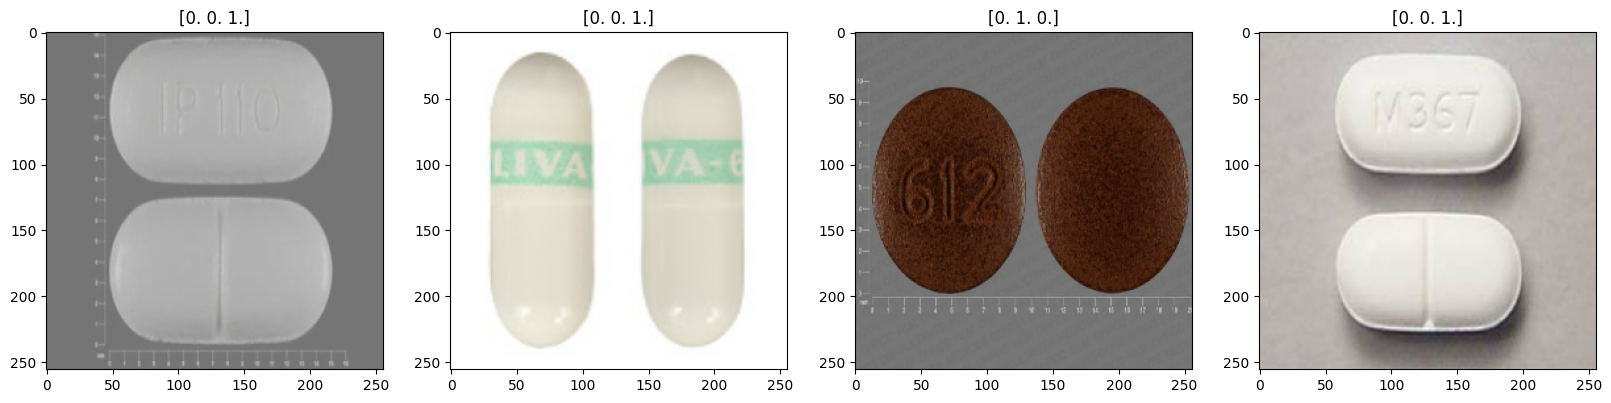

In [70]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
plt.show()

2.2 Split the data

In [71]:
len(data)

10

In [72]:
train_size=int(len(data)*.7)
val_size=int(len(data)*.2)
test_size=int(len(data)*.1)

In [73]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

3. Deep model

3.1 Build a deep learning model

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [79]:
model=Sequential()

In [80]:
# First Conv Layer
model.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second Conv Layer
model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Third Conv Layer
model.add(Conv2D(128, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output Layer (for 3 classes)
model.add(Dense(3, activation='softmax'))

In [81]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      67,109,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,500,099 (257.49 MB)

 Trainable params: 67,500,099 (257.49 MB)

 Non-trainable params: 0 (0.00 B)

3.2 Train

In [83]:
logdir='logs'

In [84]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [85]:
hist=model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.4345 - loss: 1.0328 - val_accuracy: 0.5625 - val_loss: 0.7529
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5890 - loss: 0.9017 - val_accuracy: 0.8906 - val_loss: 0.5903
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8077 - loss: 0.6614 - val_accuracy: 0.9062 - val_loss: 0.3315
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8403 - loss: 0.4650 - val_accuracy: 0.9219 - val_loss: 0.2681
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9074 - loss: 0.3000 - val_accuracy: 0.8594 - val_loss: 0.3552
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8956 - loss: 0.3261 - val_accuracy: 0.9531 - val_loss: 0.1757
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9116 - loss: 0.2774 - val_accuracy: 0.9219 - val_loss: 0.2421
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9226 - loss: 0.2618 - val_accuracy: 0.9531 - val_loss: 0.1569
Epoch 9/

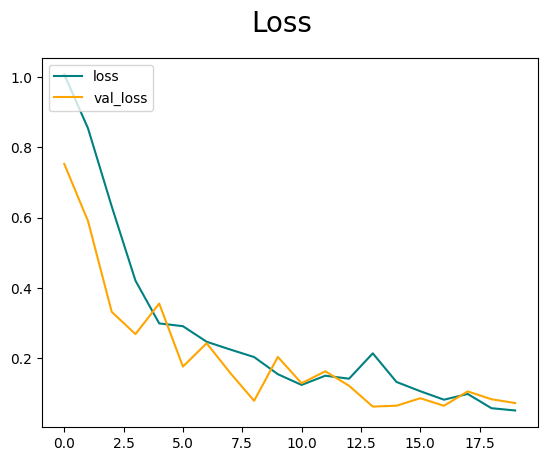

In [86]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

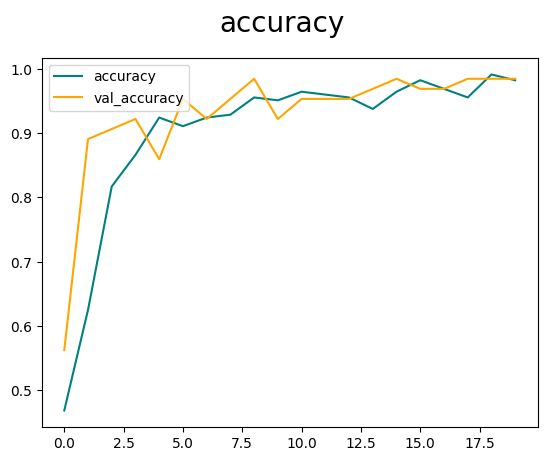

In [87]:
fig=plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

4. Evaluate performance

4.1 Evaluate

In [88]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [89]:
pre= Precision()
re= Recall()
acc= BinaryAccuracy()

In [90]:
len(test)

1

In [95]:
for batch in test.as_numpy_iterator():
    x, y =batch
    yhat= model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


In [96]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision:0.9866666793823242,Recall:0.9866666793823242,Accuracy:0.991111159324646


4.2 Test

In [97]:
import cv2

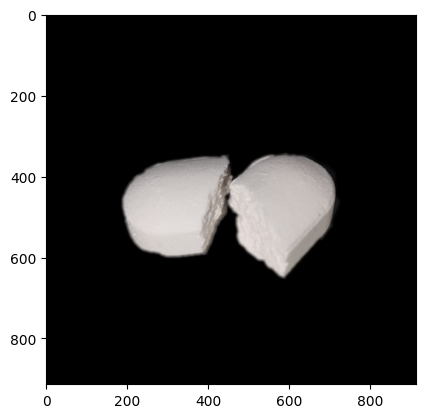

In [104]:
img=cv2.imread('cracked4.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

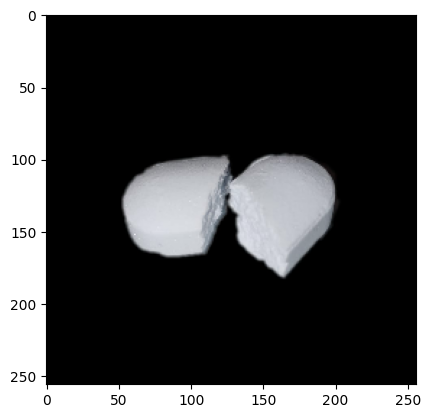

In [105]:
resize=tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [106]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [107]:
yhat

array([[0.6968893 , 0.0633162 , 0.23979451]], dtype=float32)

In [108]:
yhat.max()

0.6968893

In [110]:
class_labels = ['Cracked object', 'RED CIRCLE object', 'White oblong object']

predicted_class_index = np.argmax(yhat)

predicted_class = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class}")

Predicted class: Cracked object
